In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Имеются две базы данных (два листа `Excel-файла`): база с ценами конкурентов (`Data_Parsing`) и внутренняя база компании (`Data_Company`).

В базе парсинга есть два `id`, однозначно определяющие товар: `producer_id` и `producer_color`.

В базе компании есть два аналогичных поля: `item_id` и `color_id`.

Нам известно, что коды в двух базах отличаются наличием набора служебных символов. В базе парсинга встречаются следующие символы: `_`, `-`, `~`, `\\`, `/`.

Необходимо:

Считать данные из `Excel` в `DataFrame` (`Data_Parsing`) и (`Data_Company`).
Подтянуть к базе парсинга данные из базы компании (`item_id`, `color_id`, `current_price`) и сформировать столбец разницы цен в `%` (цена конкурента к нашей цене).
Определить сильные отклонения от среднего в разности цен в пределах бренда-категории (то есть убрать случайные выбросы, сильно искажающие сравнение). Критерий — по вкусу, написать комментарий в коде.
Записать новый файл `Excel` с базой парсинга, приклееными к ней столбцами из пункта 2 и с учётом пункта 3 (можно добавить столбец `outlier` и проставить `Yes` для выбросов).

Считать данные из `Excel` в `DataFrame`

In [235]:
xls = pd.ExcelFile('data/Data_TSUM.xlsx')
Data_parsing = pd.read_excel(xls, 'Data_Parsing') # Цены конкурентов (Parsing - разбор)
Data_company = pd.read_excel(xls, 'Data_Company') # Внетренняя база компании

data_parsing = Data_parsing.copy()
data_parsing

,brand,Category,producer_id,producer_color,price
0,Valentino,Shoes,aaaaa1111_11,black,167
1,Valentino,Shoes,aaaaa1111_12,black,188
2,Valentino,Shoes,aaaaa1111_13,black,184
3,Valentino,Shoes,aaaaa1111_14,bla//ck,196
4,Valentino,Shoes,aaaaa1111_15,bla\\ck,250
...,...,...,...,...,...
70,Stone Island,Bags,sssss1111_31,~~~red,164
71,Stone Island,Bags,sssss1111_32,~~~red,158
72,Stone Island,Bags,sssss1111_33,~~~red,194
73,Stone Island,Bags,sssss1111_34,~~~red,256


In [236]:
data_company = Data_company.copy()
data_company

,brand,Category,item_id,color_id,current price
0,Valentino,Shoes,aaaaa111111,black,247
1,Valentino,Shoes,aaaaa111112,black,161
2,Valentino,Shoes,aaaaa111113,black,234
3,Valentino,Shoes,aaaaa111114,black,167
4,Valentino,Shoes,aaaaa111115,black,153
...,...,...,...,...,...
70,Stone Island,Bags,sssss111131,red,165
71,Stone Island,Bags,sssss111132,red,196
72,Stone Island,Bags,sssss111133,red,236
73,Stone Island,Bags,sssss111134,red,222


In [237]:
def del_signs(value):
    lst = ['_', '-', '~', '\\', '/']
    for x in value:
        if x in lst:
            value = value.replace(x, '')
    return value


#       НЕ РАБОТАЕТ С DataFrame, только с Series

# def del_signs(value):
#     lst = ['_', '-', '~', '\\', '/']
#     # print(value)
#     for x in list(value):
#         print(x)
#         for i in x:
#             if i in lst:
#                 print(i)
#                 x = value.replace(i, '')
#             return x
# del_signs('aaaaa1111_11')

data_parsing['producer_id'] = data_parsing['producer_id'].apply(lambda x: del_signs(x))
data_parsing['producer_color'] = data_parsing['producer_color'].apply(lambda x: del_signs(x))
# data_parsing[['producer_id', 'producer_color', 'Category']] = data_parsing[['producer_id', 'producer_color', 'Category']].apply(lambda x: del_signs(x))

In [238]:
data_company['item_id'].nunique()

75

In [239]:
data_parsing['producer_id'].nunique()

75

In [240]:
data_company['current_price'] = data_company['current price']
data_company = data_company.drop('current price', axis=1)
data_company[['item_id', 'color_id', 'current_price']]

,item_id,color_id,current_price
0,aaaaa111111,black,247
1,aaaaa111112,black,161
2,aaaaa111113,black,234
3,aaaaa111114,black,167
4,aaaaa111115,black,153
...,...,...,...
70,sssss111131,red,165
71,sssss111132,red,196
72,sssss111133,red,236
73,sssss111134,red,222


Подтянуть к базе парсинга данные из базы компании (`item_id`, `color_id`, `current_price`)

In [241]:
merged = data_parsing.merge(
    data_company[['item_id', 'color_id', 'current_price']],
    left_on='producer_id',
    right_on='item_id',
    how='left'
)
merged = merged.drop('item_id', axis=1)
display(merged.shape)
# (100836, 6)
display(merged.head())

(75, 7)

,brand,Category,producer_id,producer_color,price,color_id,current_price
0,Valentino,Shoes,aaaaa111111,black,167,black,247
1,Valentino,Shoes,aaaaa111112,black,188,black,161
2,Valentino,Shoes,aaaaa111113,black,184,black,234
3,Valentino,Shoes,aaaaa111114,black,196,black,167
4,Valentino,Shoes,aaaaa111115,black,250,black,153


Cформировать столбец разницы цен в `%` (цена конкурента к нашей цене).

In [242]:
merged['price_difference'] = merged['price']/merged['current_price']*100
merged

,brand,Category,producer_id,producer_color,price,color_id,current_price,price_difference
0,Valentino,Shoes,aaaaa111111,black,167,black,247,67.611336
1,Valentino,Shoes,aaaaa111112,black,188,black,161,116.770186
2,Valentino,Shoes,aaaaa111113,black,184,black,234,78.632479
3,Valentino,Shoes,aaaaa111114,black,196,black,167,117.365269
4,Valentino,Shoes,aaaaa111115,black,250,black,153,163.398693
...,...,...,...,...,...,...,...,...
70,Stone Island,Bags,sssss111131,red,164,red,165,99.393939
71,Stone Island,Bags,sssss111132,red,158,red,196,80.612245
72,Stone Island,Bags,sssss111133,red,194,red,236,82.203390
73,Stone Island,Bags,sssss111134,red,256,red,222,115.315315


Определить сильные отклонения от среднего в разности цен в пределах бренда-категории (то есть убрать случайные выбросы, сильно искажающие сравнение). Критерий — по вкусу, написать комментарий в коде.

In [243]:
merged.groupby('Category')['price_difference'].mean()

Category
Bags     102.040045
Shoes    103.146771
Name: price_difference, dtype: float64

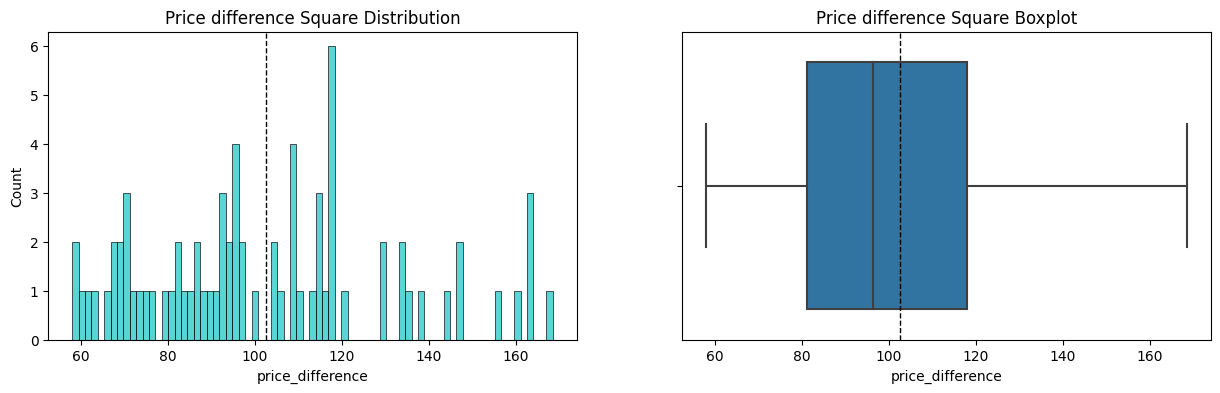

In [244]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=merged, x='price_difference', ax=axes[0], bins=75, color='c', edgecolor='k', alpha=0.65);
histplot.set_title('Price difference Square Distribution');
histplot.axvline(merged['price_difference'].mean(), color='k', linestyle='dashed', linewidth=1);
boxplot = sns.boxplot(data=merged, x='price_difference', ax=axes[1]);
boxplot.set_title('Price difference Square Boxplot');
boxplot.axvline(merged['price_difference'].mean(), color='k', linestyle='dashed', linewidth=1);

In [245]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(
    merged, 'price_difference', 3, 3, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу z-отклонения: 0
Результирующее число записей: 75


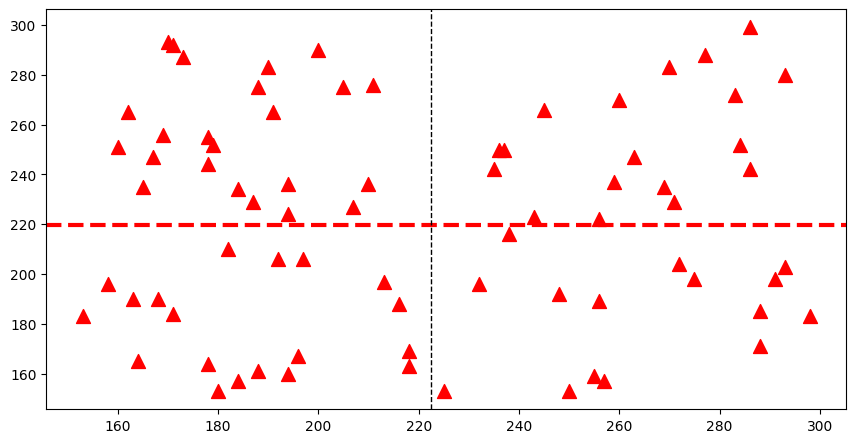

In [246]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=merged['price'], 
    y=merged['current_price'], 
    s=100,
    marker='^',
    c = 'red'
    );
axes.axhline (y=np.nanmean (merged['price']), color='red', linestyle='--', linewidth= 3 , label='Avg');
axes.axvline(merged['current_price'].mean(), color='k', linestyle='dashed', linewidth=1);